In [69]:
import os
import warnings

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important}; </style>"))

In [27]:
warnings.filterwarnings(
    action='ignore',
    message='înternal gelsd'
)

In [28]:
np.random.seed(1)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

In [29]:
# Matplotlib set label size
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

In [30]:
sns.set_style('whitegrid')
sns.set_context(
    'notebook',
    font_scale=1,
    rc={
        'lines.linewidth': 2,
        'font.family': [u'times']
    }
)

## Data Exploration

We have multiple houses, and we want to predict their **market price**.
So we are going to explore the features that we have.

In [48]:
train_set = pd.read_csv('./data/train_set.csv', index_col=0)
test_set = pd.read_csv('./data/test_set.csv')

In [34]:
print('Number of samples: ', train_set.shape[0])
print('Number of features: ', test_set.shape[1])

Number of samples:  5432
Number of features:  21


In [49]:
train_set.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
index,,,,,,,,,,,,,,,,,,,,,
0,Aberfeldie,241 Buckley St,4,h,1380000.0,VB,Nelson,12/08/2017,7.5,3040.0,4.0,2.0,2.0,766.0,NaN,NaN,Moonee Valley,-37.75595,144.90551,Western Metropolitan,1543.0
1,Northcote,67 Charles St,2,h,1100000.0,SP,Jellis,20/05/2017,5.5,3070.0,2.0,1.0,1.0,189.0,NaN,NaN,Darebin,-37.77670,144.99240,Northern Metropolitan,11364.0
2,Balwyn North,42 Maud St,3,h,1480000.0,PI,Jellis,15/10/2016,9.2,3104.0,3.0,1.0,4.0,605.0,116.0,1950.0,Boroondara,-37.79510,145.06960,Southern Metropolitan,7809.0


In [51]:
def diplay_unique_values(df: pd.DataFrame):
    print('')
    for column in train_set.columns.values:
        print(f'{column.capitalize()} - {train_set[column].dtype} - ', train_set[column].nunique())
    
diplay_unique_values(train_set)

Suburb - object -  292
Address - object -  5400
Rooms - int64 -  8
Type - object -  3
Price - float64 -  1458
Method - object -  5
Sellerg - object -  203
Date - object -  58
Distance - float64 -  194
Postcode - float64 -  187
Bedroom2 - float64 -  11
Bathroom - float64 -  9
Car - float64 -  10
Landsize - float64 -  1131
Buildingarea - float64 -  435
Yearbuilt - float64 -  121
Councilarea - object -  32
Lattitude - float64 -  3568
Longtitude - float64 -  3790
Regionname - object -  8
Propertycount - float64 -  289


In [47]:
# In the case of the Addres, we can see that would not provide a lot of information to have such a categorical variable
train_set.drop(['Address'], axis=1, inplace=True)
test_set.drop(['Address'], axis=1, inplace=True)

In [99]:
# We can assess how many nulls we have from each column
train_set.columns[train_set.isna().any()].tolist()

['Car', 'BuildingArea', 'YearBuilt', 'CouncilArea']

### Categorical Variables

In [52]:
# Can take a closer look to the object ones
train_set.select_dtypes(include=['object']).head(3)

,Suburb,Address,Type,Method,SellerG,Date,CouncilArea,Regionname
index,,,,,,,,
0,Aberfeldie,241 Buckley St,h,VB,Nelson,12/08/2017,Moonee Valley,Western Metropolitan
1,Northcote,67 Charles St,h,SP,Jellis,20/05/2017,Darebin,Northern Metropolitan
2,Balwyn North,42 Maud St,h,PI,Jellis,15/10/2016,Boroondara,Southern Metropolitan


### Type

<AxesSubplot: xlabel='count', ylabel='Type'>

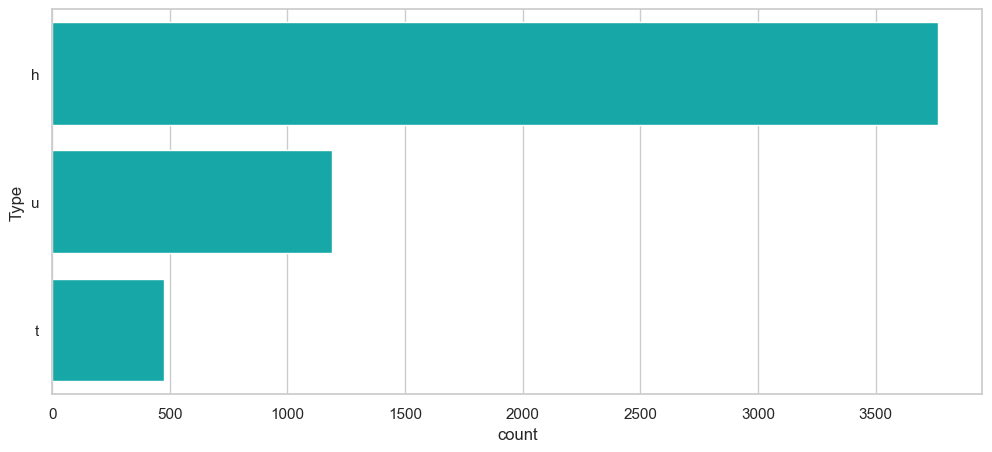

In [53]:
sns.countplot(
    y='Type',
    data=train_set,
    color='c'
)

We have the different types:
- **h**: hourse, cottage, villa, semi, terrace
- **u**: unit, duplex
- **t**: townhouse

And we can see that the majority of them are of type *h*.

### Region Name

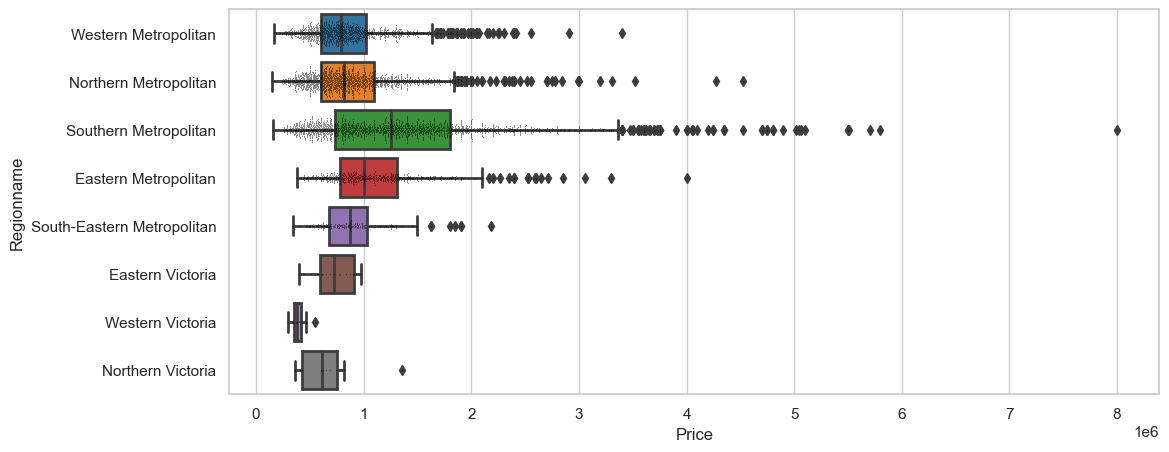

In [61]:
sns.boxplot(
    x='Price',
    y='Regionname',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Regionname", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

We could see that there are some values that really represent an **outlier**.

We will handle those extreme observations, as are the ones that in the future will affect us the assumption of normalized distribution in logarithms of the prices.

In [ ]:
# 


We can see that there is a difference in the visualization on the distribution.

We might have to do a test to know if this difference of distributions is important to take into consideration. For this, we could make an ANOVA test.

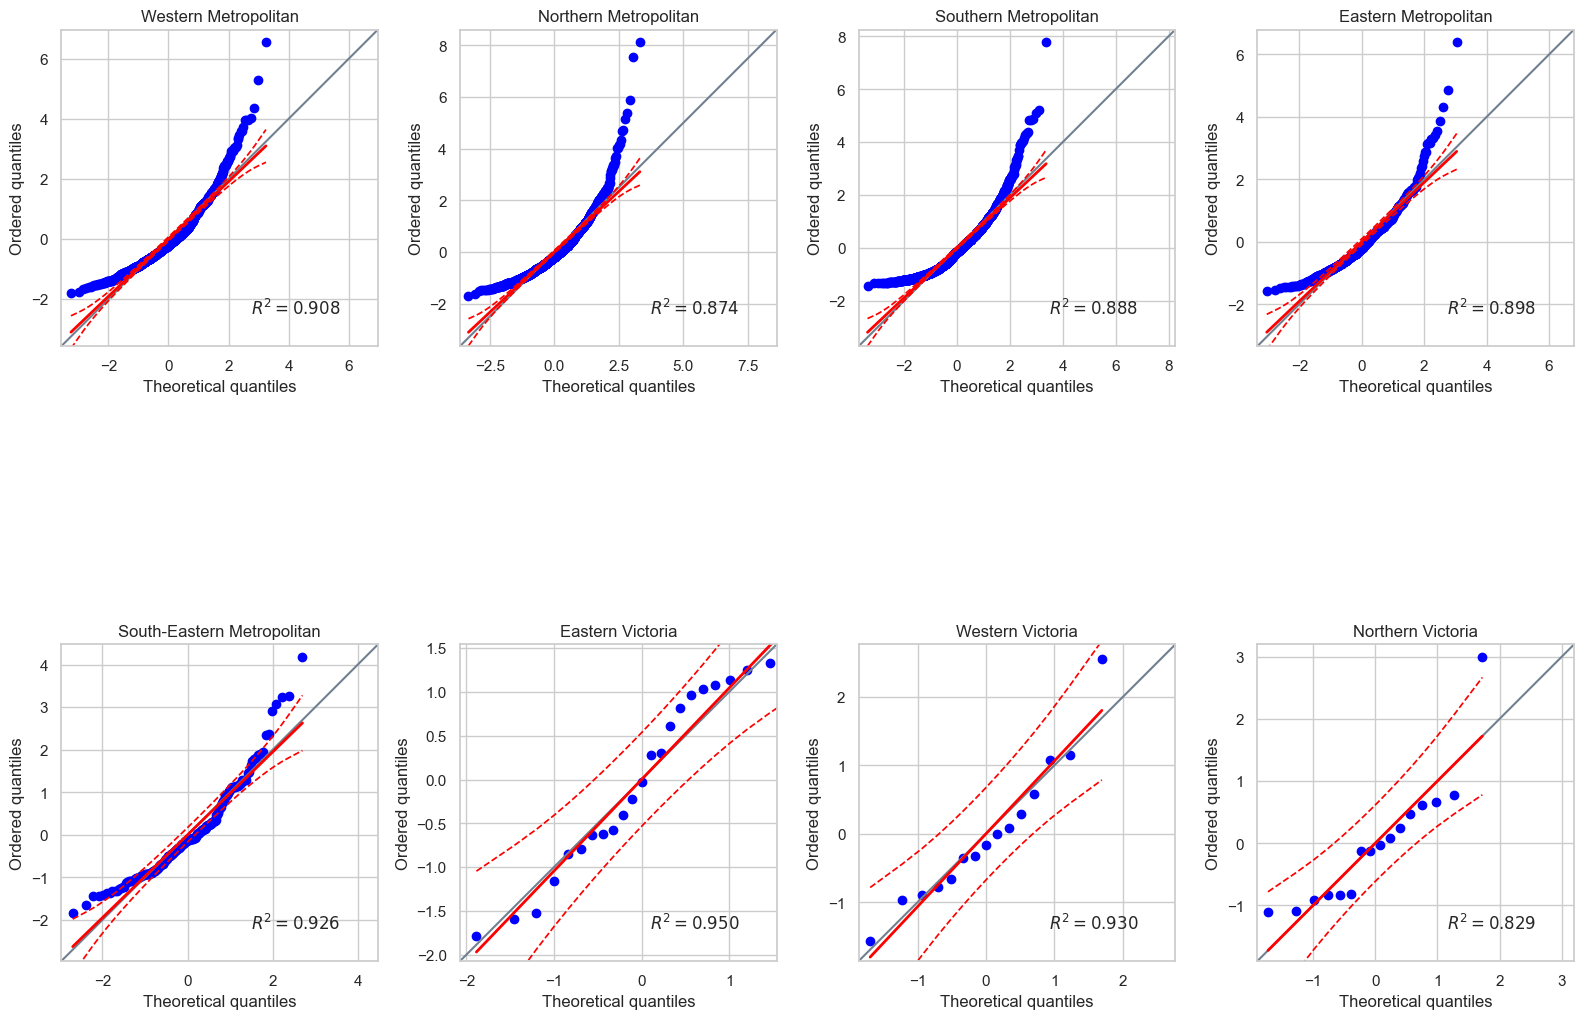

In [86]:
def qqplot_price_region(df: pd.DataFrame, price_col: str):
    # Consider normality of price distribution in each group to apply ANOVA 
    fig, axs = plt.subplots(2, 4, figsize=(16, 14))

    for idx, value in enumerate(df.Regionname.unique()):
        x_row = 1 if idx > 3 else 0
        y_col = idx if idx < 4 else idx - 4

        region_set = df.loc[df.Regionname.eq(value), price_col]

        pg.qqplot(
            region_set, 
            dist='norm', 
            ax=axs[
                x_row, 
                y_col
            ]
        )
        axs[x_row, y_col].set_title(value)

    plt.tight_layout()

qqplot_price_region(train_set, 'Price')

In [78]:
# We can also make the test Shapiro-Wilk to assess the normality
pg.normality(
    data=train_set, 
    dv='Price', 
    group='Regionname'
)

,W,pval,normal
Regionname,,,
Western Metropolitan,0.908763,5.270409e-26,False
Northern Metropolitan,0.875101,2.028653e-33,False
Southern Metropolitan,0.888327,8.951211e-35,False
Eastern Metropolitan,0.899865,3.658458e-19,False
South-Eastern Metropolitan,0.927933,2.473737e-08,False
Eastern Victoria,0.929644,1.074470e-01,True
Western Victoria,0.942243,4.114184e-01,True
Northern Victoria,0.843051,1.078405e-02,False


In [83]:
# We can make Levene homoscedasticity test
pg.homoscedasticity(
    data=train_set, 
    dv='Price', 
    group='Type', 
    method='levene'
)

,W,pval,equal_var
levene,200.494301,9.817999e-85,False


So we can only say at most that we have **normal distributions** for two of the regions: Eastern & Western Victoria.

We can try to create the logarithm of the price, and try to assess again the normality of the distribution.

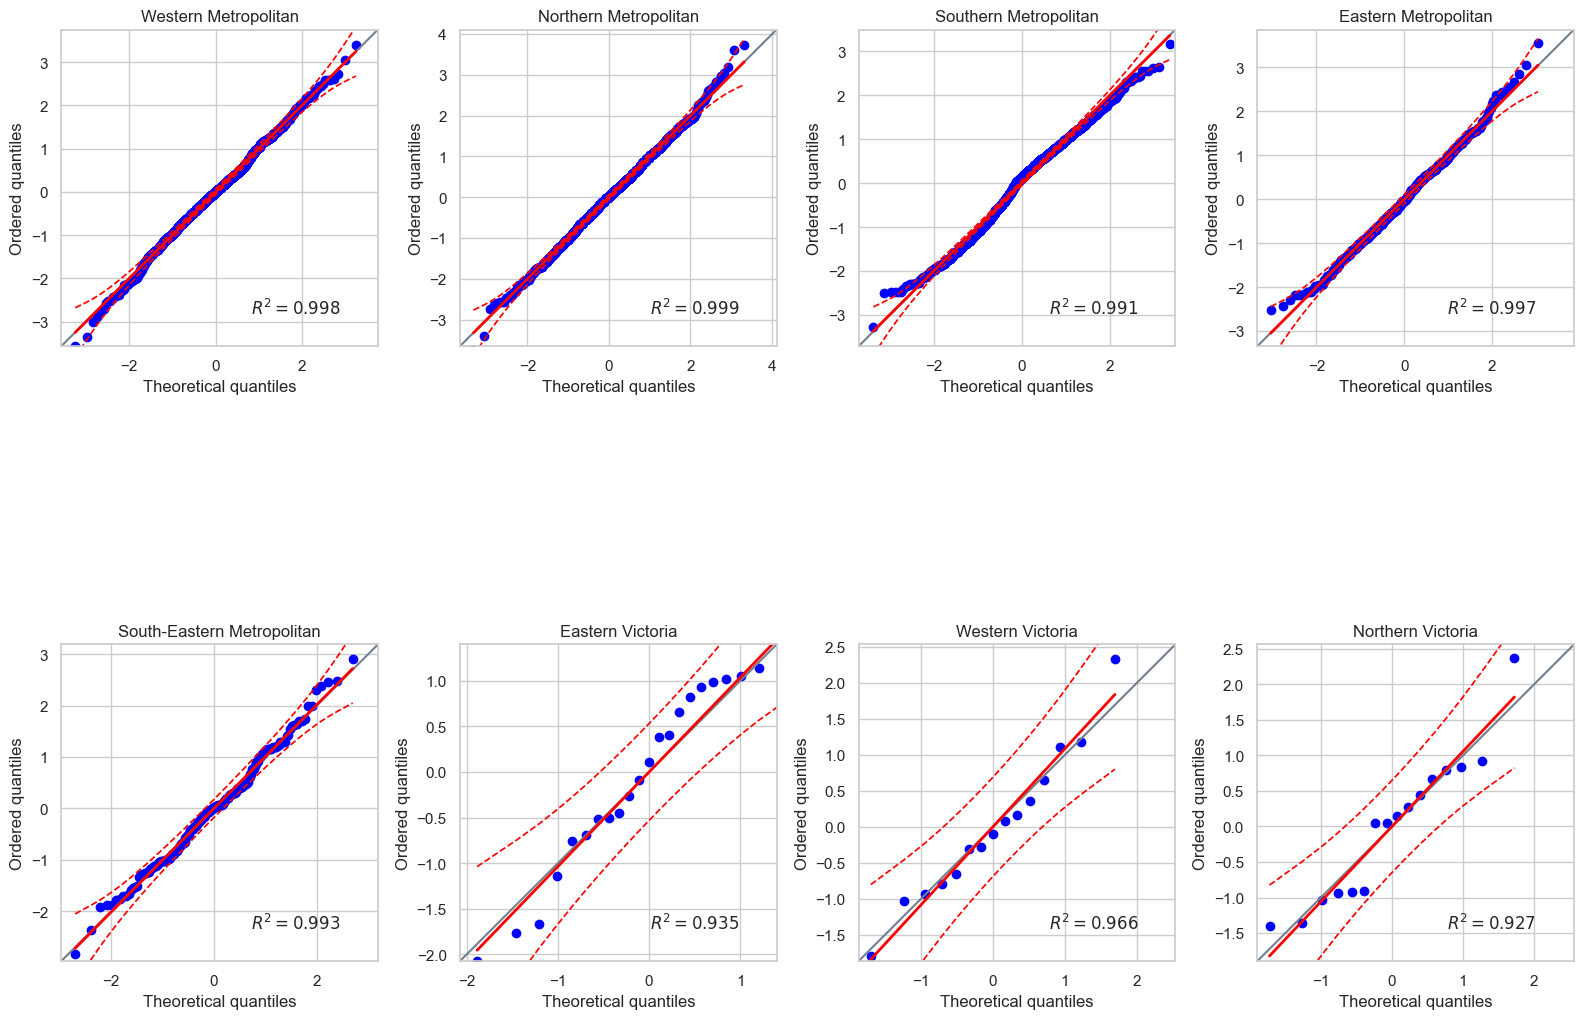

In [87]:
train_set['Price_log'] = np.log(train_set.Price)

qqplot_price_region(train_set, 'Price_log')

In [88]:
pg.normality(
    data=train_set, 
    dv='Price_log', 
    group='Regionname'
)

,W,pval,normal
Regionname,,,
Western Metropolitan,0.998090,2.000025e-01,True
Northern Metropolitan,0.998826,4.083296e-01,True
Southern Metropolitan,0.990819,1.762538e-09,False
Eastern Metropolitan,0.996283,1.853159e-01,True
South-Eastern Metropolitan,0.993599,5.461606e-01,True
Eastern Victoria,0.919121,6.379469e-02,True
Western Victoria,0.975875,9.335374e-01,True
Northern Victoria,0.925994,2.104936e-01,True


So now we can see that now we effectively have a normal distribution of the prices divided by the regions.

So we can make now an ANOVA, to assess which is the influence of the Region Name on the logarithm of the pricing.

In [91]:
pg.anova(
    data=train_set, 
    dv='Price_log', 
    between='Regionname', 
    detailed=True
)

,Source,SS,DF,MS,F,p-unc,np2
0,Regionname,178.317765,7,25.473966,102.636204,1.687837e-141,0.116965
1,Within,1346.218863,5424,0.248197,NaN,NaN,NaN


We have very small **p-value**, which means that we could reject the null hyphotesis that the means of the logarithmic prices across Region Names are the same.

## Numerical Variables

To start with this, we can first compute which is the correlation between the numerical variables.

<AxesSubplot: >

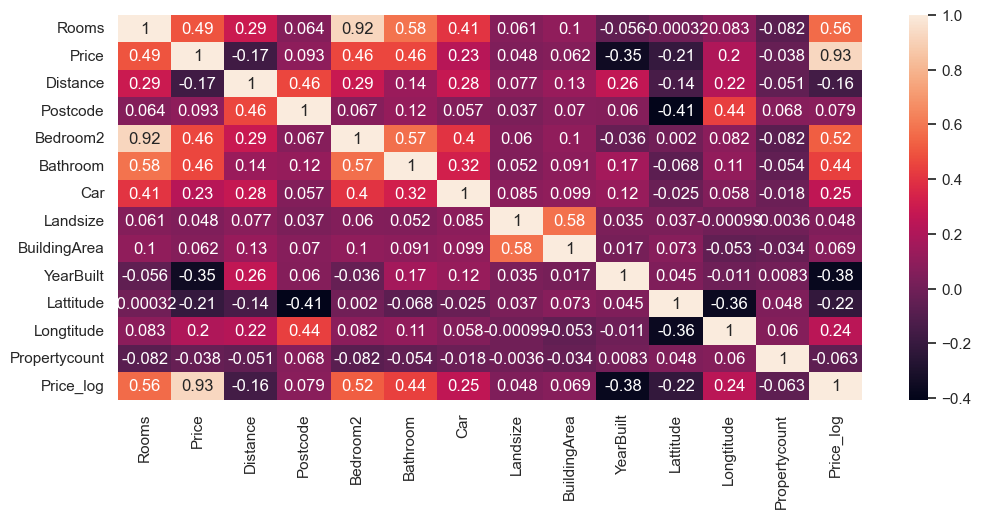

In [104]:
sns.heatmap(
    train_set.corr(numeric_only=True),
    annot=True
)

# Feature Engineering

Date Feature Enginering:
- Year / Month in which it was sold

Normalization of features (for LR, in case of Trees not be necessary).

PCA.

## TODO's

- With one hot encoding, the U of Type could be skipped (multi-collinearity if we have all of them)
- Create model for predicting building area / landsize & infer nan -> LR for type of house and landsize
- Buildyear based on KNN, 
- Filter by the outliers 
- Each model for division
- Train/val split
- Data with same ranges as test (and same parameters for conversion/normalization)